In [100]:
import csv
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib.ticker as MT
import matplotlib.lines as L
import matplotlib.cm as CM
from matplotlib import cm
import matplotlib.colors as C
import matplotlib.patches as PA
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import pickle 
from tol_colors import tol_cmap
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import scipy.linalg as scila
from scipy import linalg
from scipy import optimize
import scipy
import time
import os

plt.close('all')
plt.style.use('default')
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 14})
start = 0.0
stop = 1.0
number_of_lines= 10
cm_subsection = np.linspace(start, stop, number_of_lines) 
colors = [ cm.hsv(x) for x in cm_subsection ]

cmap = tol_cmap('rainbow_discrete', 10)
colors = cmap(1.0)
colors = [ cmap(x) for x in cm_subsection ]


LEGEND_FONT_SIZE = 22
AXIS_FONT_SIZE = 22
TICKS_FONT_SIZE = 16
LINE_WIDTH = 3.0

base_dir = 'dataset/'
logs_dir = 'logs/'

# Como Water Dam Control
### This project considers 64 years of operation of the water dam in the Como Lake basin 
### We will fit policies (parametrized regressors) that will mimic the operation of the dam operators 
### The operation consists in deciding the amount of water to be released (measured in $m^3 / s$)
### We will predict the water realease based on a list of features, including the water level, day of year, water demand etc.

## We define some helper visualization methods

In [101]:
def plotSimplex(points, fig=None, 
                vertexlabels=['1','2','3'],
                **kwargs):
    """
    Plot Nx3 points array on the 3-simplex 
    (with optionally labeled vertices) 
    
    kwargs will be passed along directly to matplotlib.pyplot.scatter    
    Returns Figure, caller must .show()
    """
    
    if(fig == None):        
        fig = plt.figure(figsize=(3, 3))
    # Draw the triangle
    l1 = L.Line2D([0, 0.5, 1.0, 0], # xcoords
                  [0, np.sqrt(3) / 2, 0, 0], # ycoords
                  color='gray', linewidth=1)
    
    fig.gca().add_line(l1)
    fig.gca().xaxis.set_major_locator(MT.NullLocator())
    fig.gca().yaxis.set_major_locator(MT.NullLocator())
    plt.axis('off')
    # Draw vertex labels
    fig.gca().text(-0.2, -0.15, vertexlabels[0])
    fig.gca().text(0.75, -0.15, vertexlabels[1])
    fig.gca().text(0.4, np.sqrt(3) / 2 + 0.05, vertexlabels[2])
    # Project and draw the actual points
    projected = projectSimplex(points)
    plt.scatter(projected[:,0], projected[:,1], **kwargs)              
    # Leave some buffer around the triangle for vertex labels
    fig.gca().set_xlim(-0.2, 1.2)
    fig.gca().set_ylim(-0.2, 1.2)

    return fig    

def projectSimplex(points):
    """ 
    Project probabilities on the 3-simplex to a 2D triangle
    
    N points are given as N x 3 array
    """
    # Convert points one at a time
    tripts = np.zeros((points.shape[0],2))
    for idx in range(points.shape[0]):
        # Init to triangle centroid
        x = 1.0 / 2
        y = 1.0 / (2 * np.sqrt(3))
        # Vector 1 - bisect out of lower left vertex 
        p1 = points[idx, 0]
        x = x - (1.0 / np.sqrt(3)) * p1 * np.cos(np.pi / 6)
        y = y - (1.0 / np.sqrt(3)) * p1 * np.sin(np.pi / 6)
        # Vector 2 - bisect out of lower right vertex  
        p2 = points[idx, 1]  
        x = x + (1.0 / np.sqrt(3)) * p2 * np.cos(np.pi / 6)
        y = y - (1.0 / np.sqrt(3)) * p2 * np.sin(np.pi / 6)        
        # Vector 3 - bisect out of top vertex
        p3 = points[idx, 2]
        y = y + (1.0 / np.sqrt(3) * p3)
      
        tripts[idx,:] = (x,y)

    return tripts

# Read the raw data about water levels, releases and water demand
## Handle the leap years

In [5]:
demand = pd.read_csv(base_dir + 'comoDemand.txt', delimiter='  ', engine='python')
data = pd.read_csv(base_dir + 'como_data_1946_2011.txt', delimiter='  ', engine='python')

#remove last year that is incomplete
data = data[data['year'] != 2011]

#manage the 29 of february: 1 march becomes a mean
# demand = demand.drop([59])
n_days = data.groupby('year').count()['day'].values
n_years = 2011 - 1946

for i, y in enumerate(range(1946, 2011)):
    if n_days[i] == 366:
        _29_feb = data[(data['year'] == y) & (data['month'] == 2) & (data['day'] == 29)]
        _1_mar = data[(data['year'] == y) & (data['month'] == 3) & (data['day'] == 1)]
        
        new_release = (_29_feb['release'].values + _1_mar['release'].values) / 2
        new_inflow = _29_feb['inflow'].values + _1_mar['inflow'].values - new_release
        
        data.at[(data['year'] == y) & (data['month'] == 3) & (data['day'] == 1), 'release'] = new_release
        data.at[(data['year'] == y) & (data['month'] == 3) & (data['day'] == 1), 'inflow'] = new_inflow

data = data[~((data['month'] == 2) & (data['day'] == 29))]
#add demand
data['demand'] = demand.values.ravel().tolist() * n_years

data.describe()

,day,month,year,level,release,inflow,demand
count,23725.000000,23725.000000,23725.000000,23725.000000,23725.000000,23725.000000,23725.000000
mean,15.720548,6.526027,1978.000000,0.472155,156.805234,156.684693,140.104140
std,8.796432,3.447924,18.762058,0.534936,101.336281,127.990205,57.177275
min,1.000000,1.000000,1946.000000,-0.705000,18.000000,3.200000,66.824000
25%,8.000000,4.000000,1962.000000,0.020000,87.000000,82.200000,88.234000
50%,16.000000,7.000000,1978.000000,0.450000,131.000000,119.800000,120.038000
75%,23.000000,10.000000,1994.000000,0.895000,183.000000,188.800000,201.019000
max,31.000000,12.000000,2010.000000,2.640000,917.700000,1849.700000,226.158000


## The dataset contains 23725 rows, with each row representing a day from 01/01/1946 - 31/12/2010
## The dataset contains 4 features 
- date: The date for which the measurement refer to: divided in day, month and year
- level: The water level in the dam measured in meters (m)
- inflow: The water inflow recorded in the previous day measured in $ m^3/s $
- demand: The water demand from the dam users in the current day measured in $ m^3/s $
## The column release represents the regression target

## We are modelling the agent of the Reinforcement Learning Policy, by means of a parametrized policy
### The parametrized policy, takes as input the state of the environment $s_t$ and outputs a distribution of the possible actions: $a_t \sim \pi(s_t)$
### The chosen action is executed and the environment responds with the next state of the environment and a reward signal $r_{t+1}$
<img src="images/rl.png"  title="The Reinforcement Learning Framework" /> 
### We model our dataset as a stream of state-action pairs representing the sequence of actions that the dam operator executed in the specific states observed
### Our goal is to recover the reward function $R(s,a)$ that the operator is maximizing during it's operation


## We will make a linearity assumption, meaning that the reward function is parametrized as a linear function of a set of $q$ known (given by domain experts) feature functions
## $R(s,a) = \omega \phi(s,a)$, where $\omega \in R^q$ and $\phi: S \times A \rightarrow R^q$

## Our goal is to find the set of weights $\omega$. To do this first we need to design a state and policy space and fit apolicy that accurately predicts the trajectories in the dataset

# 1. Policy and State Space Design

In [6]:
min_max_scaler = MinMaxScaler()

#Actions
action = data['release'].values.ravel()

#State features
height = data['level'].values.ravel()
inflow_today = data['inflow'].values.ravel()
inflow = np.concatenate(([inflow_today[0]], inflow_today[:-1]))
demand = data['demand'].values.ravel()



# Plot some of the state features

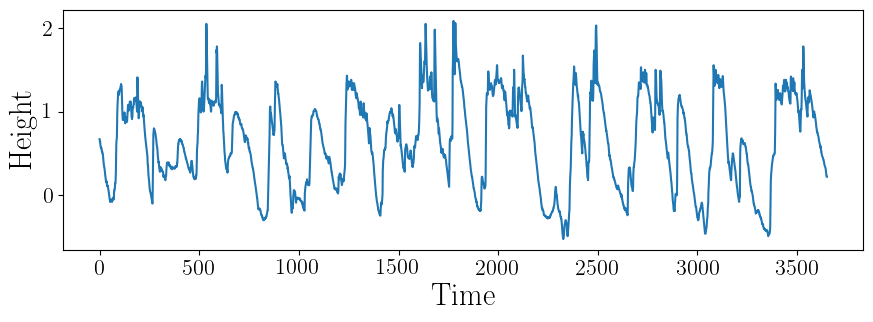

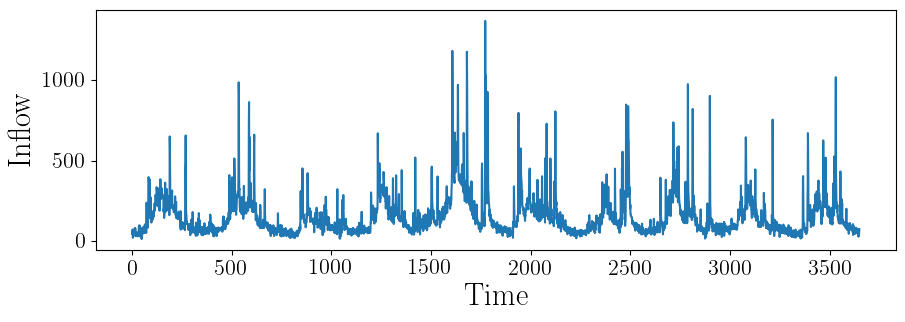

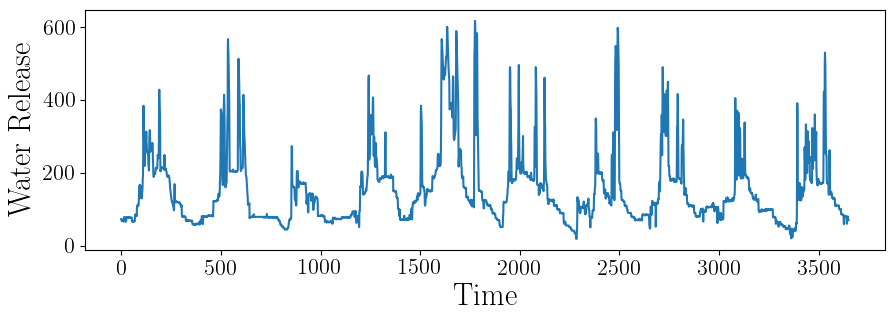

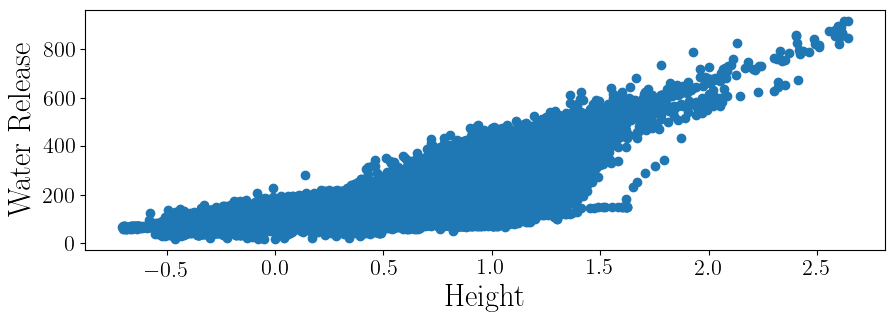

In [7]:
start_year = 1
num_years = 10
height_ = height[start_year * 365:(start_year + num_years) * 365]
fig= plt.figure(figsize=(10,3))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.set_xlabel('Time', fontsize=AXIS_FONT_SIZE)
axes.set_ylabel('Height', fontsize=AXIS_FONT_SIZE)
axes.tick_params(labelsize=TICKS_FONT_SIZE)
plt.plot(height_)

inflow_ = inflow[start_year * 365:(start_year + num_years) * 365]
fig= plt.figure(figsize=(10,3))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.set_xlabel('Time', fontsize=AXIS_FONT_SIZE)
axes.set_ylabel('Inflow', fontsize=AXIS_FONT_SIZE)
axes.tick_params(labelsize=TICKS_FONT_SIZE)
plt.plot(inflow_)

action_ = action[start_year * 365:(start_year + num_years) * 365]
fig= plt.figure(figsize=(10,3))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.set_xlabel('Time', fontsize=AXIS_FONT_SIZE)
axes.set_ylabel('Water Release', fontsize=AXIS_FONT_SIZE)
axes.tick_params(labelsize=TICKS_FONT_SIZE)
plt.plot(action_)


fig= plt.figure(figsize=(10,3))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.set_xlabel('Height', fontsize=AXIS_FONT_SIZE)
axes.set_ylabel('Water Release', fontsize=AXIS_FONT_SIZE)
axes.tick_params(labelsize=TICKS_FONT_SIZE)
plt.scatter(height, action)

## By plotting the water level and water inflow as a function of time we see that there is a periodicity to the process, related to the periodicity in the yearly seasons
## Moreover we observe an expected positive relation  between the water release and the water level, with some uncertainty for low water levels

# We start by performing a linear regression on the basic state consisting of water level, height and inflow

In [8]:
test_size = 0.2
seed = 12345
# Split X and y into train and test
state = np.array([height, inflow, demand]).T
state =  min_max_scaler.fit_transform(state)
action = min_max_scaler.fit_transform(action[:, None])
y = action
X_train, X_test, y_train, y_test = train_test_split(state, y, test_size=test_size, random_state=seed)

    
m = LinearRegression(fit_intercept=True)       
m.fit(X_train, y_train)
y_predict = m.predict(X_test)
print("R2 score ", r2_score(y_test, y_predict))
print("Coefficients: ", m.coef_)

R2 score  0.7738772805028338
Coefficients:  [[0.22192786 0.95060846 0.04104631]]


## We achieve an R2 score of 0.77 which is not bad, but is not enough to accurately predict the operator behavior
## We fist investigate if more complex regressors are able to outperform a linear regressor with just 3 state features

# We start with a RandomForest Regressor and perform a randomized search Cross Validation on some of the hyperparameters
# A RF is not suitable for our use case, as we will need a parametrized policy space, but it will be an indication if the state space needs to be extended

In [10]:
r2_scorer = make_scorer(r2_score,
                        greater_is_better=True)

n_estimators = [int(x) for x in np.linspace(start = 5, stop = 100, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
parameters = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
model = RandomForestRegressor()
cv = RandomizedSearchCV(model, parameters, scoring=r2_scorer, cv=4, refit=True, n_jobs=-1, n_iter=100)
cv.fit(X_train, y_train)
pd.DataFrame(cv.cv_results_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.190496,0.002981,0.005716,0.000068,5,2,4,77,True,"{'n_estimators': 5, 'min_samples_split': 2, 'm...",0.855147,0.859173,0.856570,0.865325,0.859054,0.003898,43
1,3.315836,0.022923,0.083246,0.002099,89,5,4,100,True,"{'n_estimators': 89, 'min_samples_split': 5, '...",0.867330,0.868346,0.869105,0.876186,0.870242,0.003489,10
2,0.915383,0.007678,0.017499,0.000330,15,10,2,55,False,"{'n_estimators': 15, 'min_samples_split': 10, ...",0.816792,0.810643,0.806722,0.829381,0.815884,0.008579,70
3,6.379189,0.047401,0.115990,0.002365,100,10,1,None,False,"{'n_estimators': 100, 'min_samples_split': 10,...",0.804700,0.797168,0.797023,0.816898,0.803947,0.008096,72
4,2.827542,0.023952,0.061433,0.002172,36,2,1,32,False,"{'n_estimators': 36, 'min_samples_split': 2, '...",0.754641,0.760138,0.751996,0.777308,0.761021,0.009852,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.554594,0.012982,0.039171,0.000821,36,2,4,32,True,"{'n_estimators': 36, 'min_samples_split': 2, '...",0.865301,0.868618,0.868449,0.875646,0.869504,0.003785,18
96,1.196886,0.028606,0.023397,0.000382,15,2,2,55,False,"{'n_estimators': 15, 'min_samples_split': 2, '...",0.785475,0.789459,0.781737,0.804673,0.790336,0.008716,88
97,5.140180,0.090197,0.062409,0.003122,89,10,4,100,False,"{'n_estimators': 89, 'min_samples_split': 10, ...",0.820168,0.820977,0.820461,0.837744,0.824838,0.007457,57
98,3.303932,0.043406,0.080727,0.000900,78,10,4,55,True,"{'n_estimators': 78, 'min_samples_split': 10, ...",0.867307,0.868768,0.870016,0.877136,0.870807,0.003778,6


In [11]:
cv.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [12]:
cv.best_score_

0.8725046785091535

## We improve the performance up to 0.87 R2 score, but this is still not enough to improve accurately imitate the controller
## We check the feature importances and extend the state space

<BarContainer object of 3 artists>

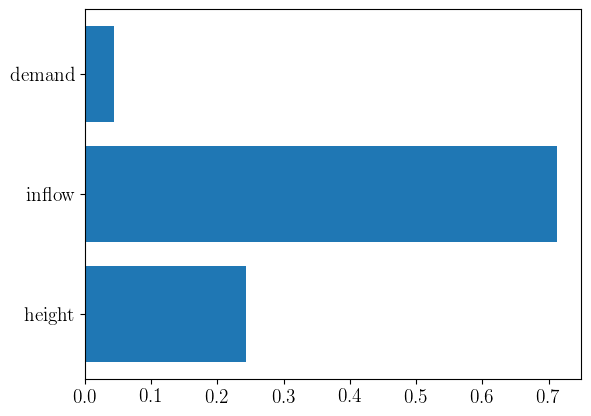

In [28]:
feature_names = ['height', 'inflow', 'demand']
plt.barh(feature_names, cv.best_estimator_.feature_importances_)

## We will extend the state space with additional features
- $sin$ and $cos$ of the day of year to account for the periodicity of the process
- $a_{t-1}$ and $a_{t-2}$ i.e. the previous releases of the operator, to account for possible non-Markovianity in the process

In [39]:
old_action = np.concatenate(([action[0]], action[:-1])).reshape((-1,))
old_old_action = np.concatenate(([old_action[0]], old_action[:-1])).reshape((-1,))
sin_t = np.sin(data['day'] / 365 * 2 * np.pi).to_numpy()
cos_t = np.cos(data['day'] / 365 * 2 * np.pi).to_numpy()
state = np.array([height, inflow, demand, old_action, old_old_action, sin_t, cos_t]).T
state =  min_max_scaler.fit_transform(state)
X_train, X_test, y_train, y_test = train_test_split(state, y, test_size=test_size, random_state=seed)

In [40]:
model = RandomForestRegressor()
cv = RandomizedSearchCV(model, parameters, scoring=r2_scorer, cv=4, refit=True, n_jobs=-1, n_iter=100)
cv.fit(X_train, y_train)
pd.DataFrame(cv.cv_results_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,5.353954,0.139926,0.045561,0.000459,47,10,4,32,False,"{'n_estimators': 47, 'min_samples_split': 10, ...",0.964465,0.968259,0.967167,0.964378,0.966067,0.001691,53
1,1.969639,0.045073,0.019322,0.001187,15,2,2,None,False,"{'n_estimators': 15, 'min_samples_split': 2, '...",0.959654,0.962477,0.956960,0.960799,0.959972,0.002008,91
2,9.159431,0.176958,0.082575,0.001228,78,5,4,32,False,"{'n_estimators': 78, 'min_samples_split': 5, '...",0.962736,0.967405,0.966309,0.964273,0.965181,0.001804,59
3,13.731990,0.169023,0.134694,0.003785,89,2,1,55,False,"{'n_estimators': 89, 'min_samples_split': 2, '...",0.953316,0.960088,0.955974,0.955761,0.956285,0.002431,98
4,0.733800,0.041071,0.007470,0.000493,5,5,1,None,False,"{'n_estimators': 5, 'min_samples_split': 5, 'm...",0.955459,0.961216,0.956895,0.957100,0.957668,0.002144,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3.913174,0.195875,0.052764,0.005903,36,5,2,77,True,"{'n_estimators': 36, 'min_samples_split': 5, '...",0.975020,0.975814,0.975501,0.974919,0.975313,0.000363,27
96,0.527648,0.003977,0.008193,0.000416,5,2,2,32,True,"{'n_estimators': 5, 'min_samples_split': 2, 'm...",0.971238,0.973870,0.972156,0.972609,0.972468,0.000948,41
97,6.753556,0.128034,0.066145,0.007317,68,2,1,77,True,"{'n_estimators': 68, 'min_samples_split': 2, '...",0.975091,0.975539,0.975113,0.974880,0.975156,0.000239,33
98,4.568560,0.068871,0.044109,0.001783,47,10,1,100,True,"{'n_estimators': 47, 'min_samples_split': 10, ...",0.975055,0.975783,0.975376,0.974285,0.975125,0.000549,34


In [41]:
cv.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=78, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [42]:
cv.best_score_

0.9758132802787394

## We improve the score to 0.97 R2 with the additional feature

In [ ]:
state_basic = X_train[:, :3]
state_day = np.concatenate([state_basic, X_train[:,-2:]], axis=1)
state_old = X_train[:, :4]
state_ = X_train[:, :5]
tests = [X_test[:, :3], np.concatenate([X_test[:, :3], X_test[:,-2:]], axis=1),
        X_test[:, :4], X_test[:, :5]]
states = [state_basic, state_day, state_old, state_]
labels = ['basic', 'state_day', 'with_old_ac', 'full']
models = []
for i, X in enumerate(states):
    m = LinearRegression(fit_intercept=True)       
    m.fit(X, y_train)
    y_predict = m.predict(tests[i])
    print("State: " + labels[i] + "; R2 score ", r2_score(y_test, y_predict))

## Finally, we fit a Linear model with the improved state, to verify wether the modified state is enough to fit the policy as a linear model to reduce the number of parameters, as it benefits the next steps in the IRL algorithm

In [46]:
## we remove sin and cos as they had low importance
state = np.array([height, inflow, demand, old_action, old_old_action]).T
state =  min_max_scaler.fit_transform(state)
X_train, X_test, y_train, y_test = train_test_split(state, y, test_size=test_size, random_state=seed)
m = LinearRegression(fit_intercept=True)       
m.fit(X_train, y_train)
y_predict = m.predict(X_test)
print("R2 score ", r2_score(y_test, y_predict))
print("Coefficients: ", m.coef_)

R2 score  0.9666441314194973
Coefficients:  [[ 0.02108464  0.25256856  0.00431682  1.10798254 -0.28543674]]


## A linear model, with the additional features is enough to achieve a high r2 score of 0.96, just 1 % point less than a RandomForest, so we will use this policy space in the next tasks

# 2. Inverse Reinforcement Learning
## In this part we will:
- Fit a linear Gaussian policy $a_t \sim N(\mu_\theta(s_t), \sigma_\theta(s_t))$
- Compute the policy gradients with respect to 3 reward features
- Recover the expert weights using \Sigma-GIRL (Ramponi, Likmeta et. al, 2020)

## Compute the 3 reward features

In [50]:
action = action = data['release'].values.ravel()
features_scaler = MinMaxScaler(feature_range=(-1, 0))
demand_power = 1
feature_demand = -np.clip(demand - np.clip(action - 5, 0, None), 0, None) ** demand_power
feature_demand = features_scaler.fit_transform(feature_demand[:, None])

min_action = np.min(action)
max_action = np.max(action)

#penalize high actions -> DRIED ranges come from expert knowledge
high_action = 500 
low_action = 5
high_power = 2
feature_high_action = - (np.clip(action, low_action, high_action) - low_action) ** high_power
feature_high_action = features_scaler.fit_transform(feature_high_action[:, None]).ravel() * (height < np.inf)
feature_high_action = features_scaler.fit_transform(feature_high_action[:, None])

#penalize low actions -> FLOODING 
high_action = 120
low_action = 5
low_power = 2
feature_low_action = - (high_action - np.clip(action, low_action, high_action)) ** low_power
feature_low_action = features_scaler.fit_transform(feature_low_action[:, None]).ravel() * (height > -0.5)
feature_low_action = features_scaler.fit_transform(feature_low_action[:, None]) 
reward_features = np.hstack([feature_demand, feature_low_action, feature_high_action])


In [54]:
#scale states
state_before_scaling =  np.array([height, inflow, demand, old_action, old_old_action]).T
state = min_max_scaler.fit_transform(state)
action = action = data['release'].values.ravel()
action_before_scaling = action
action = min_max_scaler.fit_transform(action[:, None])

np.save(base_dir + 'states.npy', state)
np.save(base_dir + 'actions.npy', action_before_scaling[:, None])
np.save(base_dir + 'reward_features.npy', reward_features)

# Plot the process over the years (average and CI)

(365, 11)


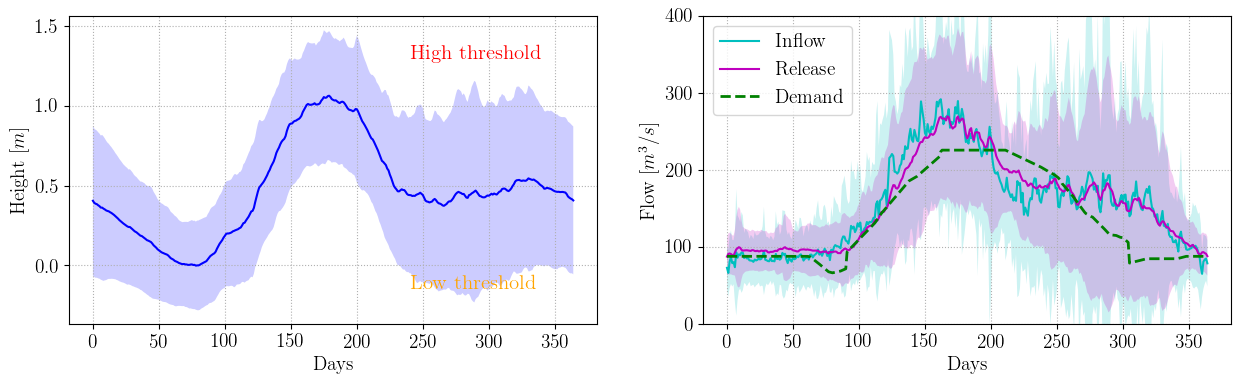

In [55]:
#[height, inflow, demand, old_action, old_old_action]

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

heights, inflows, demands, releases = [], [], [], []
for y in range(65):
    s = state_before_scaling[y*365:(y+1)*365]
    a = action_before_scaling[y*365:(y+1)*365]
    heights.append(s[:, 0])
    inflows.append(s[:, 1])
    demands.append(s[:, 2])
    releases.append(a)
    
x = np.arange(365)
height_mean, height_std = np.mean(heights, axis=0), np.var(heights, axis=0) ** 0.5
ax[0].plot(x, height_mean, color='b')
ax[0].fill_between(x, height_mean - height_std, height_mean + height_std, alpha=0.2, facecolor='b')
ax[0].set_xlabel("Days")
ax[0].set_ylabel("Height [$m$]")

ax[0].grid(linestyle=":")

ax[0].text(240, 1.3, r'High threshold', fontsize=15, color='r')
ax[0].text(240, -0.15, r'Low threshold', fontsize=15, color='orange')

inflow_mean, inflow_std = np.mean(inflows, axis=0), np.var(inflows, axis=0) ** 0.5
ax[1].plot(x, inflow_mean, label='Inflow', color='c')
ax[1].fill_between(x, inflow_mean - inflow_std, inflow_mean + inflow_std, alpha=0.2, facecolor='c')

release_mean, release_std = np.mean(releases, axis=0), np.var(releases, axis=0) ** 0.5
ax[1].plot(x, release_mean, label='Release', color='m')
ax[1].fill_between(x, release_mean - release_std, release_mean + release_std, alpha=0.2, facecolor='m')

ax[1].plot(x, demands[0], linewidth=2, linestyle="--", color='green', label='Demand')
ax[1].set_ylim([0, 400])


ax[1].set_xlabel("Days")
ax[1].set_ylabel("Flow [$m^3/s$]")

ax[1].grid(linestyle=":")

ax[1].legend(loc="upper left")

fig.savefig("analysis.pdf", bbox_inches='tight')

cols = ['days', 'inflow_mean', 'inflow_low', 'inflow_high',
       'release_mean', 'release_low', 'release_high',
       'height_mean', 'height_low', 'height_high', 'demand']

ll = np.array([x, inflow_mean, inflow_mean - inflow_std, inflow_mean + inflow_std, 
 release_mean, release_mean - release_std, release_mean + release_std,
 height_mean, height_mean - height_std, height_mean + height_std, demands[0]]).T
print(ll.shape)

## Collect the state-action-reward filles generated in the first task and define some parameters

In [104]:
states_array = np.load(base_dir + 'states.npy', allow_pickle=True)
actions_array = np.load(base_dir + 'actions.npy', allow_pickle=True)
features_array = np.load(base_dir + 'reward_features.npy', allow_pickle=True)
state_dim = states_array.shape[-1]
action_dim = actions_array.shape[-1]

ep_len = 365 # each episode is one year
init_logstd = 2.5 # policy variance
num_layers = 0
gamma = 0.999 # discount factor
norm_features = False

###### TF only parameters##### To use TF training set num_layers larger than 0 (MLP with 1+ hidden layer)
num_hidden = 8
num_epochs = 50
starting_point = ''
validation = 0.
lr = 1e-2
l2 =0.
batch_size = 128
state_std = False

## Define a class that represents the Gaussian Policy

In [67]:
class LinearGaussianPolicy:

    def __init__(self, weights=None, bias=None, noise=None):
        if weights is not None:
            self.bias = bias
            self.weights = weights
            self.output, self.input = self.weights.shape
        if noise is not None and isinstance(noise, (int,  float, complex)):
            noise = np.diag(np.ones(self.output)*noise)
        if noise is None:
            noise = np.diag(np.ones(self.output)*0)
        self.noise = noise

    def get_weights(self):
        return self.weights

    def set_weights(self, weights, noise=None):
        self.weights = weights
        self.output, self.input = self.weights.shape
        if noise is not None and isinstance(noise, (int, float, complex)):
            noise = np.diag(np.ones(self.output)*noise)
        self.noise = noise

    def _add_noise(self):
        noise = np.random.multivariate_normal(np.zeros(self.output), self.noise, 1).T
        return noise

    def act(self, X, stochastic=True):
        X = X.reshape(self.input, 1)
        y = np.dot(self.weights, X)
        if self.bias:
            y += self.bias
        if self.noise is not None and stochastic:
            y += self._add_noise()
        return y

    def step(self, X, stochastic=False):
        return None, self.act(X, stochastic), None, None

    def compute_gradients(self, X, y, diag=False):
        X = np.array(X).reshape(self.input, 1)
        y = np.array(y).reshape(self.output, 1)
        mu = np.dot(self.weights, X)
        if self.bias:
            mu += self.bias
        if diag:
            grad = np.diag((np.dot(np.linalg.inv(self.noise), np.dot((y - mu), X.T))))
        else:
            grad = (np.dot(np.linalg.inv(self.noise), np.dot((y - mu), X.T))).flatten()
        if self.bias:
            grad = np.concatenate([grad, [1]])
        return [grad], None, None, None, None

    def compute_gradients_imp(self, X, y, pi2, diag=False):
        X = np.array(X).reshape(self.input, 1)
        y = np.array(y).reshape(self.output, 1)
        mu = np.dot(self.weights, X)
        if self.bias:
            mu += self.bias
        if diag:
            grads = np.diag((np.dot(np.linalg.inv(self.noise), np.dot((y - mu), X.T))))
            grads = np.dot(np.exp(-(X-pi2.weights)**2/2)/np.sqrt(2*np.pi)/pi2.noise, grads)
        else:
            grads = (np.dot(np.linalg.inv(self.noise), np.dot((y - mu), X.T))).flatten()
            grads = np.dot(np.exp(-(X-pi2.weights)**2/2)/np.sqrt(2*np.pi)/pi2.noise, grads)
        return grads

## Define a training function

In [83]:
def behavioral_clonning_linear(X, Y, noise=None, name=''):
    regr = LinearRegression()
    train_data = X
    train_label = Y
    regr.fit(train_data, train_label)
    pi = LinearGaussianPolicy(weights=regr.coef_, bias=regr.intercept_, noise=noise)
    model_name = 'linear'
    model_path = logs_dir + 'tensorboards/' + name + '/' + model_name + '_' + str(time.time()) + '/'
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    np.save(model_path + 'best.npy', regr.coef_)

    predictions = regr.predict(train_data)
    cost = np.sum((predictions - train_label) ** 2)

    std = 1
    ll = -np.sum(- 0.5 * np.log(2 * np.pi) - np.log(std) - 0.5 * (predictions - train_label) ** 2 / (
                std ** 2 + 1e-10))

    #print("R2 Score:" + str(regr.score(X, Y)))

    logger = {
        'training_samples': len(train_data),
        'cost': cost,
        'll': ll
    }
    return pi, logger, model_path

## We also include a training function that trains an MLP using tensorflow for completion. It is not required to be run, as a simple linear policy receives good performances, but we run these experiments with MLP before discovering the non-markovianity of the process

# We dont suggest to run this as it requires more time (training multiple models in the regime change algorithm)

In [103]:
import sys
import tensorflow as tf
import math
from tqdm import trange
import random
from gym.spaces import Box, Discrete
from baselines.common.policies_bc import build_policy
from baselines.common.models import mlp
import baselines.common.tf_util as U

def behavioral_cloning_nn(num_epochs, num_layers, num_hidden, X, Y, validation =0.2, lr=1e-4, l2=0., batch_size=128,
                          init_logstd=1., state_dependent_variance=True, starting_point='',
                          discrete=False, beta=1.0):
    input_dim = X.shape[-1]
    output_dim = Y.shape[-1]
    observation_space = Box(low=-np.inf, high=np.inf, shape=(input_dim,))
    if discrete:
        action_space = Discrete(n=len(np.unique(Y)))
    else:
        action_space = Box(low=-np.inf, high=np.inf, shape=(output_dim,))
    tf.reset_default_graph()
    config = tf.ConfigProto(
        allow_soft_placement=True,
        inter_op_parallelism_threads=8,
        intra_op_parallelism_threads=8,
        device_count={'CPU': 8}
    )

    config.gpu_options.allow_growth = True
    sess = U.make_session(make_default=True, config=config)
    network = mlp(num_hidden=num_hidden, num_layers=num_layers)
    policy_train = build_policy(observation_space, action_space, network, l2=l2, lr=lr,
                                trainable_variance=state_dependent_variance, init_logstd=init_logstd, beta=beta,
                                state_dependent_variance=state_dependent_variance)()
    U.initialize()
    if starting_point != '':
        policy_train.load(starting_point)
    # dataset build
    states = X
    actions = Y

    if discrete:
        print("Original Dataset Size:", states.shape[0])
        classes = np.unique(Y)
        class_counts = np.array([np.sum(Y == cl) for cl in classes])
        max_count = max(class_counts)
        ratios = class_counts / max_count
        print("Class Distribution:", class_counts / states.shape[0])
        print("Class ratios:", ratios)
        states_to_add = []
        actions_to_add = []
        for j, ratio in enumerate(ratios):

            if ratio != 1:
                for i in range(int(1 / ratio)):
                    states_to_add += states[actions == classes[j]].tolist()
                    actions_to_add += actions[actions == classes[j]].tolist()
                remaining = int((1 / ratio - int(1 / ratio)) * class_counts[j])
                all_indexes = np.array([x for x in range(class_counts[j])])
                random.shuffle(all_indexes)
                shuffled_indexes = all_indexes[0:remaining]
                states_to_add += states[actions == classes[j]][shuffled_indexes].tolist()
                actions_to_add += actions[actions == classes[j]][shuffled_indexes].tolist()
        states_to_add = np.array(states_to_add)
        actions_to_add = np.array(actions_to_add)
        states = np.concatenate([states, states_to_add], axis=0)
        actions = np.concatenate([actions, actions_to_add], axis=0)
        print("Oversampled Dataset Size", states.shape[0])
    dataset = list(zip(states, actions))
    random.shuffle(dataset)
    if validation > 0.:
        k = math.floor(validation * len(dataset))
        dataset_training = dataset[:-k]
        dataset_validation = dataset[-k:]
    else:
        dataset_training = dataset[:]

    # pre-processing statistics
    num_batches = len(dataset_training) // batch_size
    num_batches += (0 if len(dataset_training) % batch_size == 0 else 1)
    print('# batches: ', num_batches)
    print('# training samples: ', len(dataset_training))
    logger = {
        'training_samples': len(dataset_training),
        'batch_size': batch_size,
        'num_batches': num_batches,
        'num_epochs': num_epochs
    }
    if validation > 0.:
        print('# validation samples: ', len(dataset_validation))
        logger['validation_samples'] = len(dataset_validation)

        # validation samples built
        X_val, y_val = zip(*dataset_validation)
        X_val, y_val = np.array(X_val), np.array(y_val)
    # train + accuracy over epochs
    counter = 0
    best_loss = np.inf
    for epoch in trange(num_epochs):
        # train batches built
        random.shuffle(dataset_training)
        batches = []
        for i in range(num_batches):
            base = batch_size * i
            batches.append(dataset_training[base: base + batch_size])
        # train
        if validation > 0.:
            target = y_val
            accuracy, _, loss = policy_train.evaluate(X_val[:], target, False)
            if epoch % 1 == 0 and loss <= best_loss:
                best_loss = loss
        else:
            pass
        for batch in batches:

            batch_X, batch_y = zip(*batch)
            target = batch_y
            output = policy_train.fit(batch_X, target)
            summaries = [tf.Summary.Value(tag="loss", simple_value=output[0]),
                         tf.Summary.Value(tag="r2", simple_value=output[1])]
            if not discrete:
                summaries += [tf.Summary.Value(tag="mean_std", simple_value=output[2]),
                              tf.Summary.Value(tag="min_std", simple_value=output[3]),
                              tf.Summary.Value(tag="max_std", simple_value=output[4])]
            else:
                summaries += [tf.Summary.Value(tag="entropy", simple_value=output[2]),
                              tf.Summary.Value(tag="stochastic_accuracy", simple_value=output[3])]
            counter += 1
        # validation
    if validation > 0.:
        target = y_val
        accuracy, _, loss = policy_train.evaluate(X_val[:], target, False)
        summary = tf.Summary(value=[tf.Summary.Value(tag="accuracy", simple_value=accuracy),
                                    tf.Summary.Value(tag="test_loss", simple_value=loss)])
        if num_epochs % 1 == 0 and loss <= best_loss:
            best_loss = loss
    batch_X, batch_Y = zip(*dataset)
    _, _, loss, ll = policy_train.evaluate(batch_X[:], batch_Y[:], False)
    logger['cost'] = loss
    logger['ll'] = ll
    return policy_train, logger, None

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

ModuleNotFoundError: No module named 'baselines'

## Helper class to define the policy gradient estimation. We use GPOMDP from (Peters et. al, 2006)

In [69]:
class GPOMDP():
    def __init__(self, gradient, gamma, rewards, weights=None, probs=[1]):
        self.gradients = gradient
        self.gamma = gamma
        self.weights = weights
        self.rewards = rewards
        self.probs = probs

    def eval_gpomdp(self, normalize_features=False):
        if self.weights == None:
            self.weights = 1
        if len(self.probs) == 1:
            self.probs = np.ones((self.gradients.shape))
        sn = (np.mean(self.probs, axis=0) + 1.e-10)
        discount_factor_timestep = np.power(self.gamma * np.ones(self.gradients.shape[1]),
                                                range(self.gradients.shape[1]))  # (T,)
        print(discount_factor_timestep.shape)
        discounted_return = discount_factor_timestep[np.newaxis, :, np.newaxis] * self.rewards# (N,T,L)
#         print("Feature Expectations:")
#         print(discounted_return.sum(axis=1).mean(axis=0))
        if normalize_features:
            discounted_return /= discounted_return.sum(axis=1).mean(axis=0)
#         print(discounted_return.shape)
        # print(discounted_return.cumsum(axis=1), discounted_return.cumsum(axis=1).shape)
        gradient_est_timestep = np.cumsum(self.gradients, axis=1) # (N,T,K)
#         print(gradient_est_timestep.shape)
        gradient_est_timestep2 = np.cumsum(self.gradients, axis=1) ** 2  # (N,T,K)
#         print(gradient_est_timestep2.shape)
        baseline_den = np.mean(gradient_est_timestep2, axis=0)  # (T,K)
#         print(baseline_den.shape)
        baseline_num = np.mean(
            (gradient_est_timestep2)[:, :, :, np.newaxis] * discounted_return[:, :, np.newaxis, :],
            axis=0)  # (T,K,L)
#         print(baseline_num.shape)
        baseline = baseline_num / (baseline_den[:, :, np.newaxis] + 1e-7)  # (T,K,L)
#         print(baseline.shape)
        gradient = np.sum(gradient_est_timestep[:, :, :, np.newaxis] * (discounted_return[:, :, np.newaxis, :] -
                                                                    baseline[np.newaxis, :]), axis=1)  # (N,K,L)
#         print(gradient.shape)
        return gradient

    def eval_gpomdp_discrete(self):
        if self.weights == None:
            self.weights = 1
        if len(self.probs) == 1:
            self.probs = np.ones((self.gradients.shape[0], self.gradients.shape[1]))
        discount_factor_timestep = np.power(self.gamma * np.ones(self.gradients.shape[1]),
                                                range(self.gradients.shape[1]))  # (T,)
        discounted_return = discount_factor_timestep[np.newaxis, :, np.newaxis] * self.rewards# (N,T,L)
        gradient_est_timestep = np.cumsum(self.gradients, axis=1) * self.probs[:,:,np.newaxis]  # (N,T,K, 2)
        baseline_den = np.mean(gradient_est_timestep ** 2 + 1.e-10, axis=0)  # (T,K, 2)
        baseline_num = np.mean(
            (gradient_est_timestep ** 2)[:, :, :, np.newaxis] * discounted_return[:, :, np.newaxis, :],
            axis=0)  # (T,K,2,L)
        baseline = baseline_num / baseline_den[:, :, np.newaxis]  # (T,K,2,L)
        gradient = np.mean(
            np.sum(gradient_est_timestep[:, :, :, np.newaxis] * (discounted_return[:, :, np.newaxis, :] -
                                                                    baseline[np.newaxis, :, :]), axis=1),
            axis=0)  # (K,2,L)
        return gradient

## Helper function to filter not well-behaved policy parameters (non essential / non-used)

In [89]:
def filter_grads(estimated_gradients, verbose=False):

    filter = None
    num_episodes, num_parameters, num_objectives = estimated_gradients.shape[:]
    mean = estimated_gradients.mean(axis=0)
    std = estimated_gradients.std(axis=0)
    for i in range(num_objectives):
        indexes_std = np.argwhere(np.isclose(std[:, i], 0)).ravel()
        indexes_mean = np.argwhere(np.isclose(mean[:, i], 0)).ravel()
        indeces = np.intersect1d(indexes_std, indexes_mean)
        if len(indeces) > 0:
            if filter is None:
                filter = indeces
            else:
                filter = np.intersect1d(filter, indeces)
        else:
            filter = []
    if verbose:
#         print("Filtered Indeces:", filter)
        pass
    if filter is not None and len(filter) > 0:
        estimated_gradients = np.delete(estimated_gradients, filter, axis=1)

    return estimated_gradients

# Implementation $\Sigma$-GIRL IRL algorithm from Ramponi, Likmeta et. al 2020.
## This algorithm solves a non-convex optimization problem to find a set of weights that represent the coefficients of a linear reward function with respect to a set of given reward features. 
## The algorithm takes in consideration the uncertainty derived from the gradient estimation being a sample mean over the expert trajectories

In [71]:
def estimate_cov(estimated_gradients, diag=False):
    _, num_episodes = estimated_gradients.shape[:]
    if diag:
        sigma = np.diag(np.std(estimated_gradients, axis=1)**2)
    else:
        sigma = np.cov(estimated_gradients)
    if np.any(np.isnan(sigma)):
        sigma = 1e10 * np.eye(sigma.shape[0])
    n = sigma.shape[0]
    m = np.trace(sigma) / n
    d_sym = sigma - m*np.eye(n)
    d = np.trace(np.dot(d_sym, d_sym.T)) / n
    prod = 0
    for ep in range(num_episodes):
        column = estimated_gradients[:, ep].reshape((-1, 1))
        prod_sym = np.dot(column, column.T) - sigma
        prod += np.trace(np.dot(prod_sym, prod_sym.T)) / n
    prod /= (num_episodes**2)
    b = np.minimum(prod, d)
    a = d - b
    try:
        res = b / d * m * np.eye(n) + a / d * sigma
        if np.isnan(np.max(res)):
            mu = np.mean(estimated_gradients, axis=1)

            return np.eye(len(mu))
        return res
    except:
        return np.ones(sigma.shape)
    
def estimate_distribution_params(estimated_gradients, identity=False, diag=False, cov_estimation=False,
                                 other_options=None, girl=False):

    assert ((cov_estimation or diag) != identity or cov_estimation == diag == identity == False)
    num_episodes, num_parameters, num_objectives = estimated_gradients.shape[:]
    est_grad = estimated_gradients.transpose((1, 2, 0)).reshape((num_parameters * num_objectives, num_episodes),
                                                                order='F')
    mu = np.mean(est_grad, axis=1)
    if identity:
        sigma = np.eye(len(mu))
    elif cov_estimation:
        sigma = estimate_cov(est_grad, diag) / num_episodes
    elif girl:
        sigma = np.kron(np.ones((num_objectives, num_objectives)), np.eye(num_parameters))
    else:
        if diag:
            sigma = np.diag(np.std(est_grad, axis=1) ** 2)
        else:
            sigma = np.cov(est_grad)
        sigma /= num_episodes

    return mu, sigma

## $\Sigma$-Girl solve the following non-convex optimization problem:
<img src="images/sigma.png"  title="Sigma GIRL" /> 
## where $\omega$ is the vector of reward weights that linearly parametrize the reward function, i.e. $R(s,a | \omega) = \omega * \phi(s,a)$, where $\phi$ is the given set of feature functions
## and $\widehat{\nabla}_{\theta} \psi( \theta)$ is the policy gradient estimated with GPOMDP

## To solve this non-convex optimization problem we use SLSQP, using the implementation of scipy

In [72]:
def solve_sigma_PGIRL(estimated_gradients, cov_estimation=False, diag=False, identity=False, seed=None, verbose=False,
                      num_iters=10, compute_jacobian=False, girl=False, other_options=None):
    assert ((cov_estimation or diag) != identity or cov_estimation == diag == identity == False)

    num_episodes, num_parameters, num_objectives = estimated_gradients.shape[:]
    estimated_gradients = estimated_gradients.transpose((1, 2, 0)).reshape((num_parameters*num_objectives, num_episodes), order='F')
    mu = np.mean(estimated_gradients, axis=1)
    if verbose:
        print('computed mu')
    if other_options is None:
        other_options = [False, False, False]
    if other_options[0]:
        sigma = np.ones((len(mu), len(mu)))
    elif other_options[1]:
        sigma = np.kron(np.ones((num_objectives, num_objectives)), np.eye(num_parameters))
    elif len(other_options) >= 3 and other_options[2]:
        if cov_estimation:
            sigma = estimate_cov(estimated_gradients, diag)
        elif diag:
            sigma = np.diag(np.std(estimated_gradients, axis=1) ** 2)
        else:
            sigma = np.cov(estimated_gradients)
        sigma = sigma * np.kron(np.ones((num_objectives, num_objectives)), np.eye(num_parameters)) / num_episodes
    elif identity:
        sigma = np.eye(len(mu))
    elif cov_estimation:
        sigma = estimate_cov(estimated_gradients, diag) / num_episodes
    elif girl:
        sigma = np.kron(np.ones((num_objectives, num_objectives)), np.eye(num_parameters))
    else:
        if diag:
            sigma = np.diag(np.std(estimated_gradients, axis=1) ** 2) / num_episodes
        else:
            sigma = np.cov(estimated_gradients) / num_episodes
            
    if verbose:
        print('computed cov')
    identity = np.identity(num_parameters)

    def rank_approx(w):
        w = np.reshape(w, (-1, 1))
        kr = np.kron(w, identity)
        left_exp = np.dot(kr.T, np.dot(sigma, kr))
        if verbose:
            print('left exp condition number: ', np.linalg.cond(left_exp))
        right_exp = np.linalg.solve(left_exp, np.dot(kr.T, mu))
        obj = np.dot(np.dot(mu.T, kr), right_exp)
        return obj
    obj_func = rank_approx
    constraint = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bound = (0, 1)
    bounds = [bound] * num_objectives
    if seed is not None:
        np.random.seed(seed)
    evaluations = []
    i = 0
    pbar = tqdm(total=num_iters)
    while i < num_iters:
        x0 = np.random.uniform(0, 1, num_objectives)
        x0 = x0 / np.sum(x0)
        res = optimize.minimize(obj_func,
                                x0,
                                method='SLSQP',
                                constraints=constraint,
                                bounds=bounds,
                                options={'ftol': 1e-8, 'disp': verbose})
        if res.success:
            evaluations.append([res.x, obj_func(res.x)])
            pbar.update(1)
            i += 1
    evaluations = np.array(evaluations)
    min_index = np.argmin(evaluations[:, 1])
    x, y = evaluations[min_index, :]
    pbar.close()
    r = None
    if compute_jacobian:
        vec_r = compute_r(mu, sigma, x, num_parameters)
        r = vec_r.reshape(num_parameters, num_objectives, order='F')

    return x, y, r

In [87]:
def loss(u, v):
    X = states_array[u * 365:v * 365]
    Y = actions_array[u * 365:v * 365]
    if num_layers == 0:
        pi, logs, model_path = behavioral_clonning_linear(X, Y, noise=np.exp(init_logstd))
    else:
        pi, logs, model_path = behavioral_cloning_nn(num_epochs=num_epochs, num_hidden=num_hidden,
                                                     num_layers=num_layers, X=X, Y=Y, validation=validation,
                                                     lr=lr, l2=l2, batch_size=batch_size,
                                                     init_logstd=init_logstd,
                                                     state_dependent_variance=state_std,
                                                     starting_point=starting_point)
    states = []
    actions = []
    features = []
    base = 365 * u
    stepsize = 365
    while base < v * 365:
        st = states_array[base:base + ep_len]
        act = actions_array[base:base + ep_len]
        ft = features_array[base:base + ep_len]
        states.append(st)
        actions.append(act)
        features.append(ft)
        base += stepsize
    states = np.array(states)
    actions = np.array(actions)
    features = np.array(features)

    grads = []
#     print(states.shape)
    for i in range(states.shape[0]):
        grads.append([])
        for j in range(states.shape[1]):
            st = states[i, j]
            action = actions[i, j]
            step_layers, _, _, _, _ = pi.compute_gradients(st, action)
            step_gradients = []
            for layer in step_layers:
                step_gradients.append(layer.ravel())
            step_gradients = np.concatenate(step_gradients)

            if np.isnan(step_gradients).any():
                print("NAN Grad")
            if (np.abs(step_gradients) > 10000).any():
                print("Big Grad")
            grads[i].append(step_gradients.tolist())
    gradients = np.array(grads)
    G = GPOMDP(gradients, gamma=gamma, rewards=features)
    gradients = G.eval_gpomdp(normalize_features=norm_features)
    gradients = filter_grads(gradients, verbose=True)

    values_cov, loss_cov, _ = solve_sigma_PGIRL(gradients, cov_estimation=True)
    # compute loss
    return loss_cov

# For this task, we are going to execute the Non-Stationary $\Sigma$-Girl Algorithm
## We are investigating , wether there are different regimes of intentions of the dam operators over the 65 year period depicted in our dataset. 
## We model this as a change point detection problem where we need to identify the set of possible changepoints in the 65 year interval (we do not know the number of changepoints)

## More specifically we extend a batch change detection algorithm, Opt  which  employs  a  dynamic  programming  approach  to  determine  the  optimal  solution  to  the  identification  of  the  change  points, to the IRL setting, and use as a loss function the one specified by $\Sigma$-GIRL:
<img src="images/NS-Sigma.png"  title="NS-Sigma GIRL" /> 

## This cell is heavy to compute, the project contains already the output of this cell, so you can skip to the next one

In [88]:
num_regimes = 11 # consider 6 different intervals
num_years = 65
cost = np.ones((num_regimes, num_years, num_years)) * np.inf
for u in range(num_years - 1):
    for v in range(u, num_years):
        cost[0, u, v] = loss(u, v + 1) * (v - u + 1)
np.save(logs_dir + 'cost_again.npy', cost)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []


  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 244.85it/s]


(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 268.87it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 213.43it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 207.93it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 259.45it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 271.00it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 246.00it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 281.37it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 195.56it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 260.07it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 270.62it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 273.39it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 276.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 280.83it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 279.43it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 293.49it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 275.40it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 272.93it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 278.62it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 261.30it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 276.04it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 270.13it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 261.08it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 273.57it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 199.59it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 254.84it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 227.62it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 200.85it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.63it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 213.15it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 236.99it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 248.98it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 233.15it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 276.51it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 233.50it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 238.05it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 270.87it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 233.45it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 255.76it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 236.24it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 245.00it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 264.32it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 301.21it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 287.19it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 270.48it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 275.82it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 257.67it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 265.10it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 253.41it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 255.41it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 223.22it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 270.80it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 251.39it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 218.52it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 211.57it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 227.19it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 246.34it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 228.13it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 226.87it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 209.31it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 240.97it/s]


(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 212.71it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 233.18it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 193.77it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 197.11it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 224.41it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 221.57it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 221.41it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 255.26it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 181.06it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 231.01it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 262.09it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 201.82it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 202.33it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 235.84it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 258.32it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 290.70it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 346.81it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 325.23it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 253.28it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 252.81it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 214.77it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 283.73it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 305.45it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 202.67it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 180.51it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 239.87it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 241.80it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 218.71it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 249.23it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 231.12it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 306.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 275.45it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 242.31it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 250.88it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 291.24it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 277.92it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 240.77it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 256.28it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 226.42it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.00it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 250.81it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 267.41it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 268.44it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 244.16it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 260.25it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 250.11it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 232.46it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 249.71it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 241.79it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.35it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 222.61it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.18it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 204.55it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 210.81it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 233.62it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 254.05it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 241.49it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.01it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 10/10 [00:00<00:00, 160.39it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 243.98it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 221.62it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 208.26it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 200.67it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 207.77it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 237.09it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 248.60it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 190.53it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 182.69it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 246.51it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.90it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 248.05it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 285.65it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 215.38it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 281.35it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 243.62it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 275.36it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 250.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 266.67it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 265.40it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 248.30it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 276.42it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 262.84it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 258.57it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 241.29it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 231.58it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 214.11it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 236.45it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 228.67it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 242.15it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 237.87it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 245.70it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 241.55it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 256.35it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 277.97it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 259.42it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 229.32it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 250.70it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 251.25it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 233.84it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 259.94it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.86it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 235.74it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 246.74it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 210.01it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 204.18it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 203.58it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 241.51it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.30it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 229.15it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 249.20it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 241.83it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.74it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 227.58it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 237.81it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 235.31it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 203.52it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 238.71it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 282.92it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 257.35it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 281.60it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 255.38it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 250.39it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 265.21it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 195.77it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 237.43it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 242.26it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 248.45it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 250.39it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 274.39it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 226.13it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 245.87it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 305.69it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 261.93it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 256.36it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 254.53it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 264.55it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 226.66it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 283.81it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 279.09it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 257.00it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 215.74it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 203.97it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 186.58it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 197.82it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 188.45it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 232.92it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.32it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 267.62it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 230.79it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 230.70it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 229.01it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 218.72it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.58it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 229.64it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 233.80it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 209.68it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 255.55it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 228.29it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 255.70it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 250.27it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 243.61it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 246.95it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 180.61it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 212.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.53it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 217.64it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 212.56it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 205.27it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 181.99it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 201.66it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 224.58it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.83it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 266.13it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 189.47it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 10/10 [00:00<00:00, 227.56it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 201.46it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 160.77it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 163.98it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 155.09it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 166.23it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 166.33it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 167.76it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 169.67it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 178.00it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 164.05it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 176.67it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 195.70it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 230.10it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 235.85it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 244.08it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 241.56it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 220.69it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 251.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 216.23it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 179.57it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.05it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 210.40it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 203.82it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 203.91it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 222.95it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 204.71it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 202.91it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 206.48it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 204.43it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 221.72it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 228.70it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 252.16it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 209.46it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 204.95it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 203.41it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 216.21it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.93it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 220.17it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 217.49it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 237.18it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 186.03it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 229.08it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 210.77it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 248.89it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 256.92it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 245.18it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 240.39it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 258.61it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 263.64it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 211.27it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 248.30it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 208.20it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 223.38it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 193.68it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 227.70it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 265.92it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 250.01it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 236.96it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 161.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 186.44it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 195.48it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 213.34it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 193.92it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 189.81it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 171.81it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 179.73it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 187.14it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.62it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 240.03it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 269.64it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 241.50it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 252.81it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 260.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 251.33it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 268.12it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 232.26it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 168.63it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 154.95it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.72it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 201.69it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 191.09it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 207.50it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 180.04it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 169.48it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 211.08it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 231.69it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 223.27it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 199.36it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 235.18it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 178.12it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 191.81it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 174.92it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 192.45it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 212.73it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 279.06it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 218.22it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.72it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 217.71it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 241.32it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.45it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 227.57it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 240.14it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 240.28it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 231.73it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 228.78it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 215.99it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 209.64it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 238.05it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 207.58it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 212.19it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 231.94it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 237.36it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 236.23it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 188.72it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 204.48it/s]


(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 209.76it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 319.67it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.22it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 179.06it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 208.33it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 265.16it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 255.97it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 243.62it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 253.87it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 233.29it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 281.99it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 262.94it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 287.21it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 314.33it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 272.48it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 255.33it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 237.29it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 226.94it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 292.92it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 154.70it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 189.77it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 238.02it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 172.58it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 189.73it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 188.13it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 191.11it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 214.40it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 281.20it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 272.59it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 227.14it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.65it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 253.40it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 280.79it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 251.16it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 267.11it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 226.65it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 266.85it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 239.72it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 248.99it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 244.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 229.73it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 264.70it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 253.00it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 262.27it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 243.18it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 232.12it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.75it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 203.50it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 203.19it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.05it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 221.02it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 246.49it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 221.15it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 10/10 [00:00<00:00, 169.52it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 229.65it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 317.98it/s]


(365,)
Filtered Indeces: []
(365,)


100%|██████████| 10/10 [00:00<00:00, 211.13it/s]

Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 193.77it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 229.78it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 260.49it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 207.51it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 237.08it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 232.53it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.84it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 257.20it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 238.57it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 260.33it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 260.91it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 281.26it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 240.46it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 210.27it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 237.45it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 301.29it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 179.38it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 220.65it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 251.83it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 231.55it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 189.51it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 185.27it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 206.58it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 218.15it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.81it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 237.75it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 209.63it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 227.39it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 243.81it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 259.46it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 232.81it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 221.39it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 250.76it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 250.74it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.86it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 244.76it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 226.71it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 248.71it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 208.60it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 227.64it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 255.03it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 215.75it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 231.94it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 247.71it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 200.85it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 191.68it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 233.19it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 286.24it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 266.85it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 240.12it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 225.79it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 135.83it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 229.74it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 215.43it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 199.72it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 237.07it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 250.35it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 286.44it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 244.99it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 240.00it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.39it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 258.87it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 238.95it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 243.42it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 232.61it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 252.92it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 221.53it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 192.14it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 191.21it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 255.57it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 222.95it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 224.85it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 204.19it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 245.46it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.83it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 270.75it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 277.29it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 247.24it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 235.22it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 251.18it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 214.13it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 240.74it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 228.97it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 233.60it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 236.37it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 246.60it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 241.59it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 229.87it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 230.92it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.62it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 254.47it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.79it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 213.86it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 233.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 237.96it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.73it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 192.18it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 190.80it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 224.64it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 202.53it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 227.03it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 201.20it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 183.20it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 148.95it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.21it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 249.38it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 258.71it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 263.88it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 286.42it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 270.94it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 274.72it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 265.07it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 265.06it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 305.39it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 264.91it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 310.62it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 269.86it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 282.34it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 278.66it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 211.91it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 188.74it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 235.93it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 236.85it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 205.45it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 205.21it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 246.96it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 240.71it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 238.76it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 242.34it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 232.27it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 251.50it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 251.64it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 247.85it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 218.13it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 226.78it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 250.52it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 242.01it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 235.57it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 217.85it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 194.65it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 220.28it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 216.92it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 250.75it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 236.00it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 254.51it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.95it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 213.09it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 208.40it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 230.17it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 205.82it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 244.17it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 230.44it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 249.60it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 145.91it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 171.41it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 201.00it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 250.64it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.52it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 253.58it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 285.02it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 310.22it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 279.05it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 314.82it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 303.00it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 295.32it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 303.64it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 302.51it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 269.52it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 276.71it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 339.77it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 211.19it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 228.61it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 281.51it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 204.19it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 204.53it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 220.48it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 239.52it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 202.52it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 231.50it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 258.79it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 218.35it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 241.05it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 226.68it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 212.20it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 243.23it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 224.19it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 245.16it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 255.07it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 281.23it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 212.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 222.91it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 244.52it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 215.22it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 242.44it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 256.06it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 257.24it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 250.01it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 210.51it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 226.99it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 204.46it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 240.51it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 240.87it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 229.70it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 201.99it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 10/10 [00:00<00:00, 161.21it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 169.28it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 172.55it/s]


(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 207.95it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 211.07it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 241.02it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 209.22it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 222.83it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 223.26it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 238.32it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 269.19it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 241.39it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 251.70it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 253.85it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 244.11it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.40it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 193.02it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 246.93it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 257.58it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 238.08it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 293.05it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 224.72it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 233.59it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 198.84it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.10it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 255.05it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 243.14it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 244.99it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 249.88it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 246.19it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 259.84it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 237.07it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 207.11it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 229.62it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 231.86it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 204.63it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 228.26it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 223.06it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 227.52it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 252.56it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 247.57it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.29it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 245.49it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 266.30it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 231.75it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 211.89it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 200.20it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 205.75it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 217.76it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 226.93it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 213.18it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 216.55it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 204.39it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 207.91it/s]


(365,)
Filtered Indeces: []


  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 258.11it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 258.23it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 231.22it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 246.55it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 290.37it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 350.80it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 298.41it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 301.16it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 284.55it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 258.13it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 382.91it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 243.11it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 285.44it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 265.30it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 278.44it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 275.46it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 248.76it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 206.31it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.40it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 242.32it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 236.82it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 248.57it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 241.41it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.67it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 242.02it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 277.38it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 233.50it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.75it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 198.86it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 231.99it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 230.98it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 238.41it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 240.72it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 243.16it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.78it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 232.18it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 246.35it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 232.53it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 230.27it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 221.68it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.42it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 244.20it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 228.73it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 204.00it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 221.36it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 201.89it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 186.99it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 242.02it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 247.25it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 255.13it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 246.30it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 248.24it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 251.48it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 284.53it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 267.97it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 208.55it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 241.02it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 237.74it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 288.68it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 237.04it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 224.62it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 276.34it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 264.63it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 301.10it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 221.64it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 263.36it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 223.60it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 286.26it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 248.50it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 244.40it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 265.17it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 227.84it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 268.26it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 248.85it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.92it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 260.71it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 283.08it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 259.83it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.20it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 240.14it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 235.16it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 269.16it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 243.75it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 229.14it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 242.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 224.03it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 221.59it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 227.24it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 239.14it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 250.76it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 228.37it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 265.98it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 258.93it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 213.51it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 322.39it/s]


(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 303.62it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 297.56it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 293.22it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 297.17it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 304.25it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 326.02it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 306.30it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 277.82it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 336.86it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 251.49it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 300.15it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 299.50it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 281.95it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 260.27it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 265.15it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 227.83it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 216.85it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 253.77it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 241.40it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 237.81it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 245.89it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 238.80it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 217.09it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 246.49it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 211.65it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 211.05it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 218.45it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.69it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 243.67it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 236.53it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 266.12it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 239.90it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 205.18it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 202.04it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 244.69it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 223.12it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 209.13it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 221.17it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 236.14it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 253.60it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 255.65it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 221.95it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 224.48it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 237.70it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 326.79it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 299.82it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 310.82it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 382.56it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 310.41it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 347.24it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 303.75it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 270.64it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 205.87it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 251.10it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 230.04it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 222.26it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.08it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 257.35it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 238.43it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 235.21it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.34it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 235.46it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 264.29it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.76it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 264.83it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 274.48it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 267.97it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 267.91it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 279.51it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 244.39it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 241.62it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 245.01it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 232.33it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 232.53it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 242.86it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 235.58it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 243.50it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 242.06it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 202.66it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 190.38it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 224.17it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 230.09it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 253.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 255.27it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 228.02it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 302.92it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 335.09it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 353.03it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 311.09it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 343.45it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 345.42it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 320.33it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 330.75it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 292.39it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 258.69it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 226.64it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 262.98it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 251.28it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 214.78it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 214.04it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 267.45it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 250.80it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 251.42it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 270.89it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 245.48it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 249.40it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 250.46it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 263.93it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 252.85it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 237.94it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 247.45it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.30it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 233.09it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 220.25it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 248.75it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 232.50it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 240.39it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 241.85it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 262.57it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 256.23it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 253.52it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 237.30it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 253.43it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 224.69it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 231.03it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 256.50it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 211.52it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.56it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 252.70it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 436.59it/s]


(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 307.16it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 248.68it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 417.88it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 343.69it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 362.94it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 525.64it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 227.92it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 255.03it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 301.91it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 242.66it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 237.40it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 223.94it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 203.62it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 241.18it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 229.45it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 221.80it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 237.57it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 207.51it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 232.09it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 220.39it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 211.17it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 236.06it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 243.82it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 241.14it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 249.52it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 260.21it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 246.85it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 244.79it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 247.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 238.27it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 232.32it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 230.30it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.45it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 216.52it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 213.56it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 231.87it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 259.32it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 284.02it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 259.96it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 284.00it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 301.27it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 278.56it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 346.48it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 360.33it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 315.35it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 285.02it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 284.68it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 199.53it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 202.35it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 224.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 220.95it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 200.25it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 199.66it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 260.21it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 236.20it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 243.26it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 239.36it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 229.89it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 233.30it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 233.36it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 223.56it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 220.26it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.78it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 250.63it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 236.96it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 236.97it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 255.86it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.78it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 254.79it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 249.43it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 228.28it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 221.95it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 265.70it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 233.23it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 181.87it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 205.43it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 208.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 223.92it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 232.15it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 221.10it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 232.29it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 272.37it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 241.60it/s]


(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 331.97it/s]


(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 363.89it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 390.94it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 333.69it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 272.75it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 494.58it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 172.90it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 196.68it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 207.45it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 214.99it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 176.29it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 187.46it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 220.22it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 216.03it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 216.56it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 223.19it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 218.75it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 226.25it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 202.79it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 220.88it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 205.77it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 269.36it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 256.91it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 270.11it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 247.59it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 238.52it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 249.00it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 240.87it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 243.11it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 198.09it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 206.99it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 215.73it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 237.14it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 236.44it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 236.05it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 220.78it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 221.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 216.02it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 242.75it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 224.09it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 241.93it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 666.13it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 527.68it/s]


(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 261.98it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 281.97it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 276.92it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 167.38it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 211.66it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 224.84it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 208.01it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 208.72it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 200.32it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 238.84it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 229.04it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 226.16it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 215.88it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.36it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 216.67it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 228.70it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.89it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 226.52it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 235.76it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.34it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 246.88it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 229.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 238.63it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 228.72it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 237.56it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 254.55it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 218.99it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 237.90it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 221.76it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 220.73it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 227.11it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 210.90it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 210.16it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 240.31it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 199.92it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.68it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.58it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 501.01it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 182.33it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 214.20it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 224.60it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 172.48it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 180.34it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 195.30it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 194.86it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 179.96it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 183.45it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 202.97it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 185.71it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 200.30it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 185.99it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 196.33it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 191.44it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 204.74it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 198.30it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 192.92it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 194.51it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 224.58it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 208.80it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 214.56it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 215.96it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 207.86it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 203.25it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 226.26it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 226.57it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 191.93it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 195.87it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 228.62it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 231.18it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 177.04it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 202.94it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 208.33it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 195.77it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 220.46it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 228.88it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 270.10it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 227.62it/s]


(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 231.26it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 231.93it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 229.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 181.32it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 179.69it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 211.50it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 194.01it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 198.66it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 210.82it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 212.88it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 201.33it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 203.72it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 188.29it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 175.58it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 178.79it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 214.69it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 190.89it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 182.19it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 167.75it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 212.80it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 229.02it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 227.04it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 231.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 214.99it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 223.94it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 203.79it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 207.85it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 191.43it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 193.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 205.28it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 187.42it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 170.36it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 185.96it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 201.31it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 191.88it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 200.55it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 208.36it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 226.53it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 228.17it/s]


(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 222.60it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 194.18it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 182.74it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 185.09it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 216.67it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 185.12it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 209.17it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 177.21it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 206.80it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 190.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 213.55it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 175.20it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 162.93it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 175.29it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 208.42it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 156.31it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 155.42it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 186.03it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 240.86it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 262.14it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 244.11it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 216.49it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 243.17it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 224.69it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 217.07it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 193.87it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 197.26it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 191.70it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 217.13it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 183.33it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 205.07it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 208.18it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 235.71it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 251.72it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.45it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 249.51it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 10/10 [00:00<00:00, 621.45it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.94it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 233.40it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 196.68it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 248.75it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 212.07it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 178.70it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 193.64it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 222.94it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 169.65it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 213.52it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 202.03it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 195.02it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 196.42it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 218.65it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 185.67it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 205.66it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 193.00it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.48it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 255.11it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 218.82it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 223.17it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 174.42it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 230.48it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 212.61it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 203.25it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 175.60it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 184.38it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 218.45it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 205.18it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 207.12it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 202.98it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 231.00it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 203.87it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 224.39it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 194.64it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 219.13it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 241.33it/s]


(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 167.10it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 179.14it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 224.53it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 172.99it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 157.05it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 194.56it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 221.91it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.90it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 251.02it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 202.51it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 189.52it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 189.74it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 204.92it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 209.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 193.01it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 194.69it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 237.77it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 245.80it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 254.38it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 233.20it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 238.36it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 232.68it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 232.96it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 212.11it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 213.23it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 213.80it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 251.92it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 227.40it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 200.83it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 212.32it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 215.22it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 227.61it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 209.44it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 239.60it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 302.22it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 182.93it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 186.94it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 251.18it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 222.00it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 192.93it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 196.28it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 192.02it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 181.84it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 197.68it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 179.23it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 192.99it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 178.28it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 195.85it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 144.96it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 160.03it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 184.80it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 206.75it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 223.46it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 201.81it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.79it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 218.05it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 191.49it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 192.50it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 196.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 217.94it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 196.46it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 194.96it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 200.47it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 174.10it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 213.79it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 177.58it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 194.09it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 165.73it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 197.00it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 10/10 [00:00<00:00, 288.04it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 278.63it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 174.91it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 198.36it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 187.90it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 157.61it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 169.12it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 195.50it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 223.75it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 189.85it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 190.61it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 190.35it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 188.61it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 187.75it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 150.70it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 174.69it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.18it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 245.11it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 216.03it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 242.96it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 229.97it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 211.90it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 203.01it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 213.03it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 196.94it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.40it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 185.01it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 196.46it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 162.92it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 167.12it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 226.25it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 191.42it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 168.75it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 197.38it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 161.31it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.01it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 206.66it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 205.19it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 197.35it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 185.20it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 202.19it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 215.87it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 186.19it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 177.84it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 172.01it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 200.62it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 173.83it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 199.15it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 191.85it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 223.60it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.74it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 244.21it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 215.27it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 236.41it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.81it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 210.38it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 213.15it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 196.06it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 209.33it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 184.07it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 198.67it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 157.89it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 191.53it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 207.98it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 194.22it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 160.74it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 173.85it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 403.81it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 228.75it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 228.04it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 212.26it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 154.38it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 176.04it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 189.68it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 179.35it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 180.40it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 189.64it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 206.47it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 209.01it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 205.43it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 206.17it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 229.80it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 238.00it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 207.44it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 206.80it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 214.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 207.27it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 199.50it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 169.24it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 175.64it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 173.80it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 209.15it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 211.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 178.14it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 156.32it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 211.49it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 160.86it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 162.91it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 196.85it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 10/10 [00:00<00:00, 201.92it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 198.90it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 257.15it/s]


(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 215.82it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.76it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 235.64it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 176.28it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 199.64it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 215.39it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 214.96it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 194.15it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 156.06it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 176.99it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 217.72it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 213.73it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 217.67it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 237.46it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 241.81it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 242.84it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 216.30it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.29it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 190.05it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 216.40it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 228.91it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 197.52it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 179.46it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 179.71it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 205.87it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 206.94it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.27it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 202.52it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 256.33it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 225.34it/s]


(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 215.06it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 252.28it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 251.45it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 242.95it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 248.47it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 251.83it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 206.64it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 221.49it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 222.90it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 231.25it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 192.72it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 197.67it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 203.43it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 209.65it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 190.48it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 168.67it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 176.45it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 195.00it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 174.15it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 201.13it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 199.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 190.60it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 167.14it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 158.87it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 231.03it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 215.71it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.10it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 216.55it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 395.76it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 299.57it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 302.55it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 276.69it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 274.73it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 202.45it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.65it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 247.48it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 204.96it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 215.64it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 214.59it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 244.21it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 238.32it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 228.03it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 238.43it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 199.97it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 204.42it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 204.13it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 242.19it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 205.04it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 198.44it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 209.37it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 201.17it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 301.84it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 195.92it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 247.59it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 245.82it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 266.19it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 242.38it/s]


(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 230.90it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 260.22it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 211.49it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 243.70it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.78it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 226.97it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 224.05it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 233.16it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 239.59it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 227.29it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 165.66it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 205.51it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 197.41it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 210.69it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 197.84it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 167.10it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 176.13it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 184.30it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 185.93it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 174.71it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 203.68it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 269.83it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 255.83it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 261.09it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 206.74it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 315.72it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 248.98it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 219.24it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 276.74it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 249.38it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.47it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 246.76it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.25it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.46it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 212.11it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 238.46it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 231.21it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 183.37it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 162.66it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 227.86it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 224.62it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 222.13it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 175.37it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.76it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 206.59it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 210.07it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 182.53it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 231.31it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 259.95it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 303.22it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 253.96it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 328.57it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 306.30it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 10/10 [00:00<00:00, 252.49it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 223.09it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 280.16it/s]


(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 212.68it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 227.94it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 239.21it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 222.91it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 168.07it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 208.72it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 174.01it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 232.27it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 206.88it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 196.69it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 218.81it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 215.79it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 213.79it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 289.50it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 239.43it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 148.51it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 170.73it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 166.99it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 203.50it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 257.47it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 291.06it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 266.11it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 276.82it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 276.89it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 328.08it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 260.96it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 222.74it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.81it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 220.12it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 221.68it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 210.98it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 223.58it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 195.84it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 185.88it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 181.61it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 171.32it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 238.83it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 211.99it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 295.72it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 180.67it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 184.34it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 179.89it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 253.15it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 223.14it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 284.99it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 307.30it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 288.56it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 277.79it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 298.45it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 273.87it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 253.86it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 286.78it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 205.51it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 206.88it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 202.51it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 204.85it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 222.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 206.09it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 269.61it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 232.08it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 259.07it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 192.05it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 145.70it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 209.75it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 224.04it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 238.85it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 294.08it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 282.90it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 247.14it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.46it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 277.43it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 239.18it/s]

(365,)
Filtered Indeces: []
(365,)



100%|██████████| 10/10 [00:00<00:00, 238.82it/s]


Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 193.04it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 259.05it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 196.56it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 244.91it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 211.51it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 221.40it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 197.49it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 227.44it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.40it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 190.07it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 246.66it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 168.36it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 157.98it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 206.29it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 275.37it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 252.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 306.10it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 280.63it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 328.29it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 286.70it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 221.36it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 169.30it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 228.03it/s]


(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 287.16it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 235.11it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 207.97it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 226.47it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 214.22it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 216.28it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 223.50it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 152.95it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 167.37it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 214.75it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 165.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 155.55it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 151.87it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 230.53it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 278.05it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 304.59it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 282.67it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 311.20it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 285.01it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 10/10 [00:00<00:00, 353.21it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 233.21it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 230.28it/s]


(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 296.21it/s]


(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 212.59it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 208.16it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 243.01it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 191.16it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 205.02it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 199.93it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 216.21it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 198.21it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 292.50it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 220.85it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 221.35it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 224.75it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 246.37it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 249.16it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 266.12it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 233.84it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 256.70it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 308.50it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 209.33it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 233.57it/s]


(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 213.35it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.92it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 253.19it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.19it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 204.91it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 231.34it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 187.91it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 192.11it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 178.05it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 173.83it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 171.37it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 190.56it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 221.19it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 237.45it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 250.38it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 246.24it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 319.22it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 270.93it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 297.68it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 244.54it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 251.38it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 240.67it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 253.68it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 221.84it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 187.12it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 207.49it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 205.34it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 173.40it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 185.85it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 223.88it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 260.65it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 288.63it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 293.34it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 313.32it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 307.76it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 10/10 [00:00<00:00, 320.53it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 235.62it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 199.64it/s]


(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 202.37it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 209.60it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 216.04it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 224.65it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 222.59it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 226.93it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 248.23it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 194.66it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 186.03it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 224.39it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 284.21it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 296.01it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 302.27it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 323.98it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 331.74it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 339.21it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 245.90it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 236.73it/s]


(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 203.33it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 229.42it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 232.62it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 252.35it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.50it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.84it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 201.31it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 199.75it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 201.65it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 245.82it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 269.38it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 283.30it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 298.12it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 241.86it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 302.82it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 214.07it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 198.57it/s]


(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 194.03it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 223.55it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 204.84it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 209.12it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 174.82it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 187.68it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 194.40it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 160.23it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 239.02it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.71it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 265.40it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 276.68it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 261.08it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 260.38it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 198.11it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 171.40it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 209.95it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 250.28it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 208.02it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 205.25it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 192.63it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 175.99it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 167.42it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 218.93it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 235.55it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 265.91it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 245.07it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 288.74it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 285.23it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 212.65it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 192.71it/s]


(365,)
Filtered Indeces: []


  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 181.84it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 196.88it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 180.83it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 208.72it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 203.40it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 216.49it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 234.04it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 221.89it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 278.57it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.24it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 235.30it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 234.87it/s]


(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 202.36it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 223.10it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 188.12it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 270.51it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 211.17it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 287.04it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 282.97it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 292.07it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 307.07it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 230.22it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 310.97it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 225.15it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 193.02it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 170.23it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 155.42it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 186.35it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 223.09it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 237.04it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 236.37it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 206.32it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 233.44it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 256.70it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 290.89it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 10/10 [00:00<00:00, 325.64it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 187.02it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.98it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 193.00it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 211.61it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 228.51it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 250.42it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 278.73it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 219.65it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 223.13it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 238.59it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 275.47it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 228.63it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 186.19it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 200.27it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 217.71it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 222.84it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 202.71it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 246.14it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 253.31it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 254.82it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 253.33it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 259.87it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 182.59it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 194.89it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 224.20it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 218.38it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 220.19it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 237.93it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 202.95it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 245.89it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 214.07it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 237.49it/s]


(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 222.20it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 223.09it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 208.18it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 191.44it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 208.26it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 205.77it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 200.38it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 232.69it/s]


(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 204.06it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 211.92it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 228.29it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 184.82it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 207.17it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 10/10 [00:00<00:00, 212.45it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)



100%|██████████| 10/10 [00:00<00:00, 229.16it/s]


Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 252.96it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 210.46it/s]


(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 221.31it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 189.20it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 231.51it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 10/10 [00:00<00:00, 160.58it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 206.16it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 241.20it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 239.11it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 186.41it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 10/10 [00:00<00:00, 145.71it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 185.68it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 190.01it/s]


(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 192.13it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 225.26it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 232.72it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 176.80it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 194.87it/s]

(365,)
Filtered Indeces: []



100%|██████████| 10/10 [00:00<00:00, 214.04it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 236.63it/s]


(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 252.40it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 275.37it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 10/10 [00:00<00:00, 868.33it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []



  0%|          | 0/10 [00:00<?, ?it/s]

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 282.70it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 10/10 [00:00<00:00, 194.48it/s]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: 

(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []
(365,)
Filtered Indeces: []


100%|██████████| 10/10 [00:00<00:00, 209.11it/s]


(365,)
Filtered Indeces: []


# Execute Opt (Aminikhanghahi and Cook 2017) using as loss function the $\Sigma$-GIRL loss specified before

In [90]:
logger_all = {'num_layers': num_layers,
              'num_hidden': 0,
              'state_std': False,
              'num_regimes': num_regimes}
n_regimes = num_regimes
for num_regimes in np.arange(1, n_regimes, dtype=int):
    for k in range(2, num_regimes):
        k_idx = k - 1
        for u in range(num_years - k + 1):
            for v in range(u + k - 1, num_years):
                candidates = [cost[k_idx - 1, u, t] + cost[0, t + 1, v] for t in range(u + k - 2, v)]
                cost[k_idx, u, v] = np.min(candidates)

    # Find idxs
    L = np.zeros(num_regimes, dtype=int)
    L[num_regimes - 1] = num_years - 1
    for k_idx in range(num_regimes - 1, 0, -1):
        s = L[k_idx]
        candidates = [cost[k_idx - 1, 0, t] + cost[0, t + 1, s] for t in range(k_idx - 1, s)]
        t_star = np.argmin(candidates) + k_idx - 1
        L[k_idx - 1] = t_star

    L = np.concatenate(([-1], L))
    L_start = L[:-1] + 1
    L_stop = L[1:]

    logger_all['intervals'] = (L_start, L_stop)
    logger_all['bc_losses'] = np.zeros(num_regimes)
    logger_all['irl_weights'] = [{} for _ in range(num_regimes)]
    logger_all['irl_losses'] = [{} for _ in range(num_regimes)]

    total_loss = 0.
    for u, v in zip(L_start, L_stop):
        print(u, v, cost[0, u, v])
        total_loss += cost[0, u, v]

    print('Loss Change Point Detection:', total_loss)
    print('Loss No Change Point Detection:', cost[0, 0, -1])

    logger_all['irl_total_loss'] = total_loss
    logger_all['irl_total_loss_no_detection'] = cost[0, 0, -1]
    logger_all['bc_total_loss'] = 0.
    for ii, (u, v) in enumerate(zip(L_start, L_stop + 1)):
        print('INTERVAL: [%s, %s]' % (u, v))
        X = states_array[u * 365:v * 365]
        Y = actions_array[u * 365:v * 365]

        if num_layers == 0:
            pi, logs, model_path = behavioral_clonning_linear(X, Y, noise=np.exp(init_logstd))
#             print(pi.weights, pi.bias)
        else:
            pi, logs, model_path = behavioral_cloning_nn(num_epochs=num_epochs, num_hidden=num_hidden,
                                                         num_layers=num_layers, X=X, Y=Y,
                                                         validation=validation, lr=lr, l2=l2,
                                                         batch_size=batch_size,
                                                         init_logstd=init_logstd,
                                                         state_dependent_variance=state_std,
                                                         starting_point=starting_point)
        logger_all['bc_losses'][ii] = logs['ll']
        logger_all['bc_total_loss'] += logs['ll']

        states = []
        actions = []
        features = []

        base = 365 * u
        stepsize = 365
        while base < v * 365:
            st = states_array[base:base + ep_len]
            act = actions_array[base:base + ep_len]
            ft = features_array[base:base + ep_len]
            states.append(st)
            actions.append(act)
            features.append(ft)
            base += stepsize

        states = np.array(states)
        actions = np.array(actions)
        features = np.array(features)

        grads = []
        for i in range(states.shape[0]):
            grads.append([])
            for j in range(states.shape[1]):
                st = states[i, j]
                action = actions[i, j]
                step_layers, _, _, _, _ = pi.compute_gradients(st, action)
                step_gradients = []
                for layer in step_layers:
                    step_gradients.append(layer.ravel())
                step_gradients = np.concatenate(step_gradients)

                if np.isnan(step_gradients).any():
                    print("NAN Grad")
                if (np.abs(step_gradients) > 10000).any():
                    print("Big Grad")
                grads[i].append(step_gradients.tolist())
        gradients = np.array(grads)
        G = GPOMDP(gradients, gamma=gamma, rewards=features)
        gradients = G.eval_gpomdp(normalize_features=norm_features)
        gradients = filter_grads(gradients, verbose=True)

        values_cov, loss_cov, _ = solve_sigma_PGIRL(gradients, cov_estimation=True)
        values_pgirl, loss_pgirl, _ = solve_sigma_PGIRL(gradients, girl=True)
        print("Sigma Girl Corrected: \t Weights:" + str(values_cov) + '\t Loss:' + str(loss_cov))
        print("Girl: \t Weights:" + str(values_pgirl) + '\t Loss:' + str(loss_pgirl))

        logger_all['irl_losses'][ii] = {'Sigma-Girl-Full': None,
                                        'Sigma-Girl-Diag': None,
                                        'Sigma-Girl-Corrected': loss_cov,
                                        'Girl': loss_pgirl}

        logger_all['irl_weights'][ii] = {'Sigma-Girl-Full': None,
                                         'Sigma-Girl-Diag': None,
                                         'Sigma-Girl-Corrected': values_cov,
                                         'Girl': values_pgirl}

    with open(logs_dir + 'res_non_stationary_%s.pickle' % num_regimes, 'wb') as f:
        pickle.dump(logger_all, f, protocol=pickle.HIGHEST_PROTOCOL)

0 64 3.4024607148526
Loss Change Point Detection: 3.4024607148526
Loss No Change Point Detection: 3.4024607148526
INTERVAL: [0, 65]


100%|██████████| 10/10 [00:00<00:00, 363.20it/s]

(365,)
Sigma Girl Corrected: 	 Weights:[0.32440621 0.47954745 0.19604635]	 Loss:0.05234554946862219
Girl: 	 Weights:[0.37890899 0.40407778 0.21701324]	 Loss:36.300097088902916
0 49 0.3722038474402549
50 64 0.06516303180489368
Loss Change Point Detection: 0.4373668792451486
Loss No Change Point Detection: 3.4024607148526
INTERVAL: [0, 50]



100%|██████████| 10/10 [00:00<00:00, 367.33it/s]

(365,)
Sigma Girl Corrected: 	 Weights:[0.43473166 0.3668396  0.19842874]	 Loss:0.0074440769484112
Girl: 	 Weights:[0.43395008 0.36771148 0.19833844]	 Loss:8.968179425744937
INTERVAL: [50, 65]



100%|██████████| 10/10 [00:00<00:00, 436.67it/s]

(365,)
Sigma Girl Corrected: 	 Weights:[5.43188339e-01 9.81186025e-17 4.56811661e-01]	 Loss:0.004344202120326015
Girl: 	 Weights:[5.43155359e-01 5.90890184e-18 4.56844641e-01]	 Loss:47.188091341221146
0 11 0.014152382535789453
12 50 0.08102636028832423
51 64 0.05505762881028504
Loss Change Point Detection: 0.1502363716343987
Loss No Change Point Detection: 3.4024607148526
INTERVAL: [0, 12]



100%|██████████| 10/10 [00:00<00:00, 401.33it/s]

(365,)
Sigma Girl Corrected: 	 Weights:[0.         0.92659387 0.07340613]	 Loss:0.0011793651648179233
Girl: 	 Weights:[4.63974460e-17 9.26078526e-01 7.39214766e-02]	 Loss:55.578954253672954
INTERVAL: [12, 51]



100%|██████████| 10/10 [00:00<00:00, 291.26it/s]

(365,)
Sigma Girl Corrected: 	 Weights:[0.57222094 0.19128257 0.23649649]	 Loss:0.002077598981694486
Girl: 	 Weights:[0.56566526 0.20067862 0.23365612]	 Loss:4.523296591843413
INTERVAL: [51, 65]



100%|██████████| 10/10 [00:00<00:00, 385.49it/s]

(365,)
Sigma Girl Corrected: 	 Weights:[0.53180214 0.         0.46819786]	 Loss:0.003932687772167847
Girl: 	 Weights:[0.44618662 0.12276391 0.43104947]	 Loss:44.26538393555133
0 11 0.014152382535789453
12 37 0.03789098213559114
38 56 0.0102767599637618
57 64 0.00542059368893664
Loss Change Point Detection: 0.06774071832407903
Loss No Change Point Detection: 3.4024607148526
INTERVAL: [0, 12]



100%|██████████| 10/10 [00:00<00:00, 407.35it/s]

(365,)
Sigma Girl Corrected: 	 Weights:[4.35045269e-18 9.26594106e-01 7.34058937e-02]	 Loss:0.0011793651646323498
Girl: 	 Weights:[0.         0.92607853 0.07392147]	 Loss:55.57895425367625
INTERVAL: [12, 38]



100%|██████████| 10/10 [00:00<00:00, 345.01it/s]

(365,)
Sigma Girl Corrected: 	 Weights:[0.59025267 0.1640374  0.24570992]	 Loss:0.0014573454680171926
Girl: 	 Weights:[0.58017827 0.17795152 0.24187021]	 Loss:7.754246352546433
INTERVAL: [38, 57]



100%|██████████| 10/10 [00:00<00:00, 321.10it/s]

(365,)
Sigma Girl Corrected: 	 Weights:[0.00730933 0.98324648 0.00944419]	 Loss:0.0005408820865767207
Girl: 	 Weights:[0.03436346 0.94123883 0.02439771]	 Loss:4.292693494920444
INTERVAL: [57, 65]



100%|██████████| 10/10 [00:00<00:00, 433.86it/s]

(365,)
Sigma Girl Corrected: 	 Weights:[0.45603947 0.         0.54396053]	 Loss:0.000677574211108806
Girl: 	 Weights:[0.45606494 0.         0.54393506]	 Loss:15.642881398123487
0 3 0.00013616029671079547
4 12 0.002435252694426892
13 42 0.032311235165608826
43 56 0.015160259371791667
57 64 0.00542059368893664
Loss Change Point Detection: 0.05546350121747482
Loss No Change Point Detection: 3.4024607148526
INTERVAL: [0, 4]



100%|██████████| 10/10 [00:00<00:00, 347.12it/s]

(365,)
Sigma Girl Corrected: 	 Weights:[0.07634624 0.67611618 0.24753758]	 Loss:3.403999663825766e-05
Girl: 	 Weights:[0.08604903 0.6585622  0.25538878]	 Loss:1.8418320064042768
INTERVAL: [4, 13]



100%|██████████| 10/10 [00:00<00:00, 383.69it/s]

(365,)
Sigma Girl Corrected: 	 Weights:[0.06882459 0.85602778 0.07514764]	 Loss:0.00027058383053304313
Girl: 	 Weights:[0.08793087 0.8318526  0.08021654]	 Loss:14.01183701458454
INTERVAL: [13, 43]



100%|██████████| 10/10 [00:00<00:00, 371.07it/s]

(365,)
Sigma Girl Corrected: 	 Weights:[0.41275665 0.38362209 0.20362126]	 Loss:0.0010770411760076765
Girl: 	 Weights:[0.41341206 0.38271373 0.2038742 ]	 Loss:3.4692340096897496
INTERVAL: [43, 57]



100%|██████████| 10/10 [00:00<00:00, 352.56it/s]

(365,)
Sigma Girl Corrected: 	 Weights:[2.89508542e-18 9.37548878e-01 6.24511215e-02]	 Loss:0.0010828756694353458
Girl: 	 Weights:[0.01536762 0.91345067 0.07118171]	 Loss:12.419047942694146
INTERVAL: [57, 65]



100%|██████████| 10/10 [00:00<00:00, 417.34it/s]

(365,)
Sigma Girl Corrected: 	 Weights:[4.56039510e-01 8.67700551e-18 5.43960490e-01]	 Loss:0.0006775742111153842
Girl: 	 Weights:[4.56064944e-01 4.23397889e-17 5.43935056e-01]	 Loss:15.642881398123484


## Visualize the Results

In [95]:
n_regimes = 11
num_regimes = np.arange(1, n_regimes, dtype=int)
irl_alg_names = ['Sigma-Girl-Corrected']  
data = []
for n in num_regimes:
    with open(logs_dir + 'res_non_stationary_%s.pickle' % n, 'rb') as f:
        d = pickle.load(f)
        data.append(d)

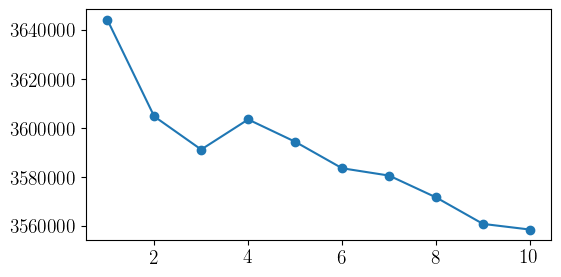

In [96]:
x = num_regimes
bc_total_loss = [d['bc_total_loss'] for d in data]

fig= plt.figure(figsize=(6, 3))
plt.plot(x, bc_total_loss, marker='o')

## As expected the loss decreases as the number of regimes increases (similar to a clustering problem
## But this is not what the algorithm optimizes, indeed we do not observe a high decrease, or an "elbow"

# Plotting the Change Points

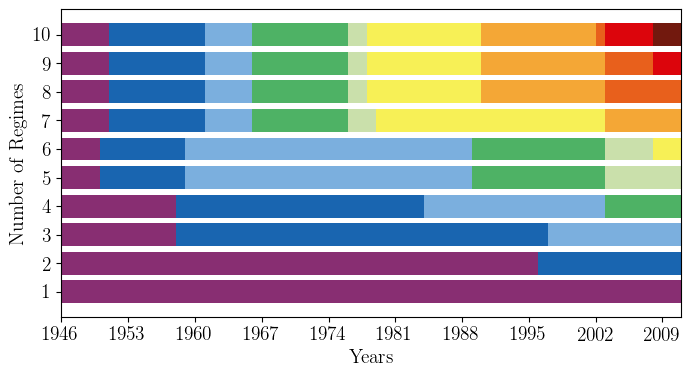

In [97]:
ys = [np.append(d['intervals'][0], d['intervals'][1][-1]+1) for d in data]
lenghts = [np.diff(y) for y in ys]
ys = [np.pad(x, (0, max(num_regimes) + 1 - len(x)), 'constant', constant_values=(x[-1], x[-1])) for x in ys]
ys = np.array(ys)

min_len = [np.min(l) for l in lenghts]

fig= plt.figure(figsize=(8, 4))
x = np.arange(len(num_regimes))
ll = [list(range(1,11))]
for i in range(len(num_regimes)):
    ll.append(ys[:, i+1] - ys[:, i])
    plt.barh(x, ys[:, i+1] - ys[:, i], left=ys[:, i], color=colors[i])

# print(np.array(ll).T)
plt.ylabel('Number of Regimes')
plt.xlabel('Years')
#plt.title('Intervals')
plt.yticks(x, num_regimes)
plt.xticks(np.arange(0, 65, 7), 1946 + np.arange(0, 65, 7))

fig.savefig(logs_dir + "intervals.pdf", bbox_inches='tight')

# IRL Loss Behaviour

Text(0.5, 1.0, 'Minimum Interval Length')

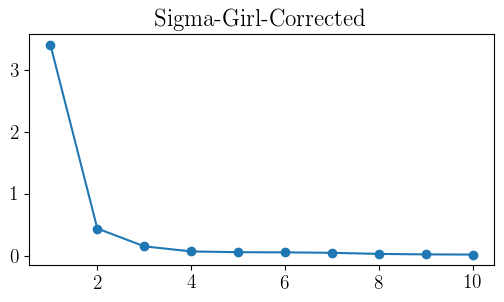

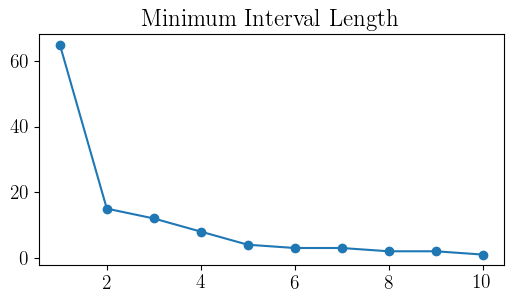

In [98]:
x = num_regimes
y = [d['irl_losses']  for d in data]


for i, alg_name in enumerate(irl_alg_names):
    fig= plt.figure(figsize=(6, 3))
    ll = []
    for n in range(len(num_regimes)):
        ll.append(np.sum([el[alg_name] for el in y[n]] * lenghts[n]))
    if alg_name == 'Sigma-Girl-Corrected':
        irl_total_loss = ll
    plt.plot(x, ll, marker='o', label=alg_name)
    plt.title(alg_name)

fig= plt.figure(figsize=(6, 3))
plt.plot(x, min_len, marker='o')
plt.title('Minimum Interval Length')

## This is indeed what the algorithm optimizes, and we see a clear elbow behavior around 3 or 4 change points, corresponding to 4 or 5 regimes of intentions shown by the operator

# Finally, we use visualize the reward function for up to 5 regimes, where domain experts identified the most matching results with the literature

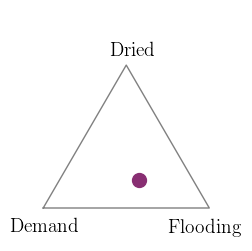

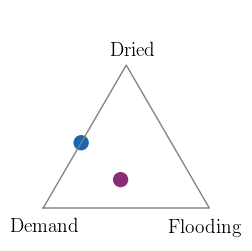

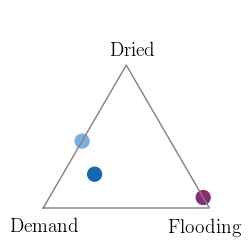

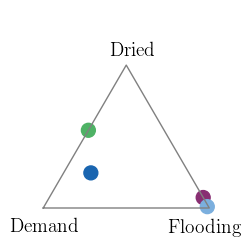

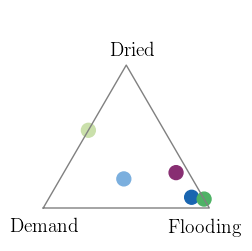

In [102]:
for n in range(5):
    points = np.array([d['Sigma-Girl-Corrected'] for d in data[n]['irl_weights']])
    fig = plotSimplex(points, s=100, vertexlabels=['Demand', 'Flooding', 'Dried'], c=colors[:len(points)])
    fig.savefig(logs_dir + "triangle_%s.pdf" % (n+1), bbox_inches='tight')